**Name:** Weida Xu (wx2198)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc

Please do one of the following.


# Part I: Classification

### 1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv", index_col=0)

In [3]:
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


### 2) Convert `default` and `student` to categorical variables.

In [4]:
df.default = LabelEncoder().fit_transform(df.default)
df.student = LabelEncoder().fit_transform(df.student)

In [5]:
df.default.value_counts()

0    9667
1     333
Name: default, dtype: int64

- Note that default is a very imbalanced class, with defaults only making up a small fraction.

In [6]:
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


### 3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

Text(0.5,0,'Student')

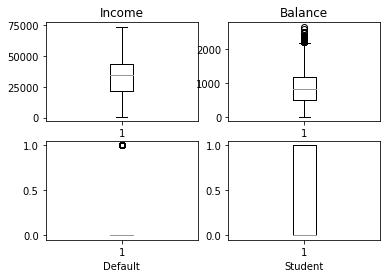

In [7]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].boxplot(df.income)
ax[0, 0].set_title('Income')
ax[0, 1].boxplot(df.balance)
ax[0, 1].set_title('Balance')
ax[1, 0].boxplot(df.default)
ax[1, 0].set_xlabel('Default')
ax[1, 1].boxplot(df.student)
ax[1, 1].set_xlabel('Student')

Text(0,0.5,'Income')

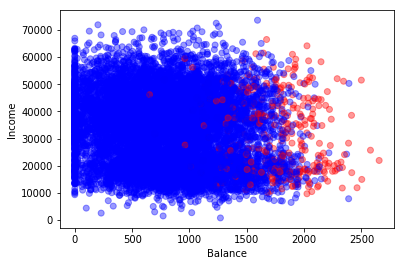

In [8]:
c = df.default
c = c.replace(1,"r").replace(0,"b")

plt.scatter(x=df.balance, y=df.income, c=c, alpha=0.4)
plt.xlabel("Balance")
plt.ylabel("Income")

### 4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based solely on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [9]:
y = df.default
X = df.loc[:,['income', 'balance']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234)

- LogisticRegression uses L2 regularisation by default. To turn off regularisation, C is set to $1\times10^{10}$ to simulate setting the weight on the penalty term to zero. In addition, a weight is applied to the `y` variable as imbalance can be observed from the boxplot above.

In [11]:
# Logistic

logreg = LogisticRegression(C=1e10, class_weight='balanced')
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
print(roc_auc_score(y_test, predictions))


0.888044947447


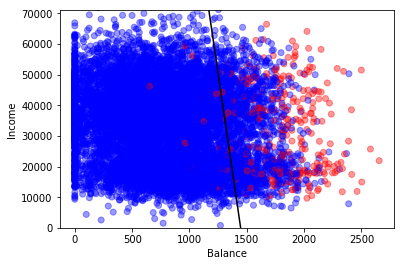

In [12]:
# Decision boundary

coeffs = logreg.coef_
w = coeffs[0]
w0 = logreg.intercept_
x = np.arange(0, 2600, 100)
y_plot = (w0 + w[1] * x) / -w[0]
plt.ylim(0, 71000)
plt.scatter(x=df.balance, y=df.income, c=c, alpha=0.4)
plt.plot(x, y_plot, c='black')
plt.xlabel("Balance")
plt.ylabel("Income")
plt.show()

Area under the ROC curve : 0.9521424680748048


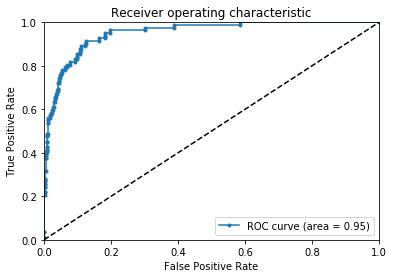

In [13]:
# Code from Dorian's Classification notebook
def generate_auc(xtest, ytest, classifier):
    probas_ = classifier.predict_proba(xtest)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : {}".format(roc_auc))
    return fpr, tpr, roc_auc, thresholds

fpr,tpr,roc_auc, thresholds = generate_auc(X_test, y_test, logreg)

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

### 5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients.  How does performance improve with the added variable?

In [16]:
# Using an L2 penalty for a regularized logistic regression
X = df.loc[:,["income", "balance", "student"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234)
logreg = LogisticRegression(class_weight='balanced', penalty = "l2")
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
print(roc_auc_score(y_test, predictions))


0.894556073352


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

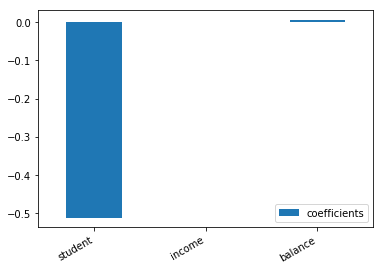

In [17]:
toplot = pd.DataFrame(logreg.coef_[0], columns=['coefficients'], index=X.columns) 
toplot.sort_values('coefficients').plot(kind='bar')
plt.xticks(rotation=30, ha='right')

- We can see that income has the largest effect, and is several orders of magnitude larger than the other two variables. This makes plotting difficult, and one should refer instead to the table above.

Area under the ROC curve : 0.9536807278742763


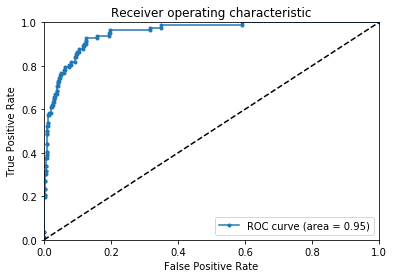

In [18]:
fpr,tpr,roc_auc, thresholds = generate_auc(X_test, y_test, logreg)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

Performance improves very slightly with the added variable and L2 penalty.

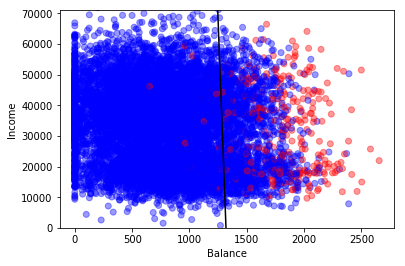

In [19]:
coeffs = logreg.coef_
w = coeffs[0]
w0 = logreg.intercept_
x = np.arange(0, 2600, 100)
y_plot = (w0 + w[1] * x) / -w[0]
plt.ylim(0, 71000)
plt.scatter(x=df.balance, y=df.income, c=c, alpha=0.4)
plt.plot(x, y_plot, c='black')
plt.xlabel("Balance")
plt.ylabel("Income")
plt.show()

### 6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [20]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234)


In [26]:
scores = cross_val_score(LogisticRegression(class_weight='balanced', penalty = "l2"), 
                                             X_train, y_train, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {}".format(np.mean(scores))) 


Mean cross-validation accuracy: 0.9465703108109811


- Performance improves with cross-validation.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [27]:
scores = cross_val_score(DecisionTreeClassifier(max_depth = 5, random_state = 1234, class_weight = "balanced"), 
                                             X_train, y_train, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 


Mean cross-validation accuracy: 0.91


- Cross validated performance deproves with regard to cross validated logistic regression with L2 regularization. This may imply that the data is mostly linearly separable and the logistic regression classifier performs well with this dataset.

8) Find the optimal decision tree depth and compute the AUC ROC. 

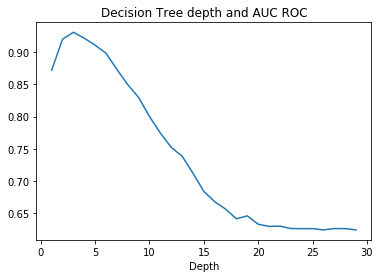

Optimal Decision Tree depth: 3
Optimal Training Score 0.9309834359010971


In [28]:
depths = np.arange(1,30)
scores = []
for depth in depths:
    dt = DecisionTreeClassifier(class_weight = "balanced", max_depth = depth, random_state = 1234)
    scores.append(np.mean(cross_val_score(dt, X_train, y_train, scoring='roc_auc', cv = cv)))
plt.plot(depths, scores)
plt.title("Decision Tree depth and AUC ROC")
plt.xlabel("Depth")
plt.show()
print("Optimal Decision Tree depth: {}".format(np.argmax(scores) + 1))
print("Optimal Training Score {}".format(np.max(scores)))

In [29]:
dt = DecisionTreeClassifier(class_weight = "balanced", max_depth = 3, random_state = 1234)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

Area under the ROC curve : 0.9368683047872661


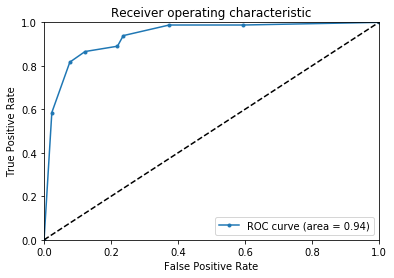

In [30]:
fpr,tpr,roc_auc, thresholds = generate_auc(X_test, y_test, dt)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

- Even when optimized, the decision tree still performs worse than the regularized logistic regression classifier.

# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 
 
You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 